# Importy a čítanie dát

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community
#!pip install isbnlib
import isbnlib
from isbnlib import meta
from isbnlib.registry import bibformatters
from numba import jit
from operator import itemgetter
#!pip install python-louvain
#!pip install community
from community import community_louvain
import matplotlib.cm as cm
import seaborn as sns

In [2]:
df = pd.read_csv('rec-amz-Books.edges', header=None, names=['ID_reviewer', 'ISBN', 'Stars', 'Date'])

# Bipartitný graf - štatistika

## Histogram recenzií

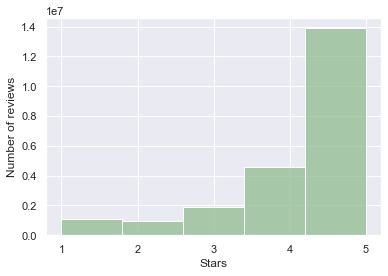

In [12]:
sns.set_theme()
fig, ax = plt.subplots()
sns.histplot(ax=ax, data=df, x='Stars', bins=5, color='darkseagreen')
ax.set_xticks(range(1,6))
ax.set_ylabel('Number of reviews')
plt.show()

## Histogram stupňa vrcholov kníh

In [22]:
df_isbn = pd.DataFrame(df['ISBN'].value_counts()).rename(columns={'ISBN':'Number of reviews'})

In [23]:
df_isbn

,Number of reviews
0439023483,21398
030758836X,19867
0439023513,14114
0385537859,12973
0007444117,12629
...,...
0821510401,1
0821508717,1
1939084261,1
1939084768,1


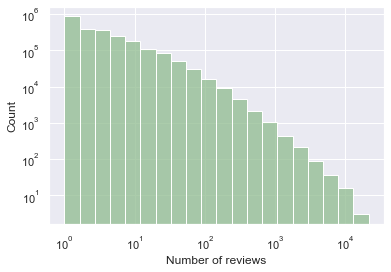

In [27]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
sns.histplot(ax=ax, data=pd.DataFrame(df['ISBN'].value_counts()).rename(columns={'ISBN':'Number of reviews'}), x='Number of reviews', bins=20, color='darkseagreen')
plt.show()

## Histogram stupňa vrcholov autorov recenzií

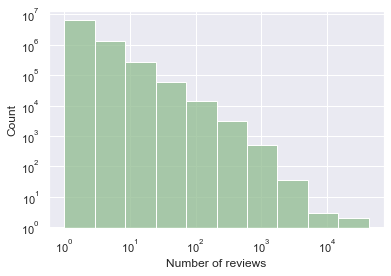

In [26]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
sns.histplot(ax=ax, data=pd.DataFrame(df['ID_reviewer'].value_counts()).rename(columns={'ID_reviewer':'Number of reviews'}), x='Number of reviews', bins=10, color='darkseagreen')
plt.show()

In [6]:
def from_ISBN_to_title(column):
    new_col = list()
    bibtex = bibformatters["json"]
    for value in column:
            try:
                isbn = str(value)
                SERVICE = 'openl'
                #print(isbn)
                new_col.append(json.loads(bibtex(meta(isbn, SERVICE)))['title'])
            except AttributeError:
                try:
                    isbn = str(value)
                    SERVICE = 'goob'
                    #print(isbn)
                    new_col.append(json.loads(bibtex(meta(isbn, SERVICE)))['title'])
                except:
                    new_col.append('---')
                    continue
            except isbnlib.NotValidISBNError:
                new_col.append('---')
            except:
                new_col.append('---')
    return new_col

## Top X najlepšie hodnotených kníh s aspoň 5 000 hodnoteniami

In [4]:
data_100 = df.groupby('ISBN').filter(lambda x : len(x)>5000)  # tie, ktoré majú aspoň 5000 recenzií

In [3]:
def get_top_x_reviewed(x, data):
    top_x = data.groupby('ISBN')['Stars'].agg(np.mean).reset_index().sort_values(by='Stars', ascending=False).head(x)
    top_x.loc[:, 'Title']= from_ISBN_to_title(top_x['ISBN'])
    return top_x

In [7]:
pd.set_option('max_colwidth', None)
get_top_x_reviewed(20, data_100)

,ISBN,Stars,Title
44,1400318130,4.865852,Jesus Calling Leatherette Large Deluxe
7,0141345713,4.795980,Fault in Our Stars
50,1491510706,4.779646,The Fault in Our Stars
2,0007386648,4.772346,Unbroken: an extraordinary true story of courage and survival
16,0316044695,4.730403,Lone survivor - the eyewitness account of Operation Redwing and the lost heroes of SEAL Team 10
33,043920352X,4.720043,Harry Potter and the Sorcerer's stone
37,0606238409,4.714409,---
9,0261103288,4.706798,The hobbit - or There and back again
36,0545265355,4.706396,Hunger Games Trilogy Boxed Set
32,0439136350,4.706212,Harry Potter and the Prisoner of Azkaban


## Top X najlepšie hodnotených kníh podľa počtu hodnotení

Knihy, ktoré majú najviac hodnotení nehľadiac na počet hviezdičiek.

In [8]:
def get_top_x_number_reviews(x, data):
    data_x = data['ISBN'].value_counts().head(x).reset_index()
    data_x.loc[:, 'Title']= from_ISBN_to_title(data_x['index'])
    data_x = data_x.rename(columns={'ISBN':"Number of reviews", 'index':'ISBN'})
    return data_x

In [9]:
get_top_x_number_reviews(20, df)

,ISBN,Number of reviews,Title
0,0439023483,21398,The Hunger Games
1,030758836X,19867,Gone Girl
2,0439023513,14114,Mockingjay
3,0385537859,12973,Inferno
4,0007444117,12629,Allegiant
5,0375831002,12571,The Book Thief
6,038536315X,12564,Sycamore row
7,0345803485,12290,Fifty Shades of Grey
8,0316055433,11746,The Goldfinch
9,0849922070,10424,Heaven is For Real Movie Edition


# Projekčná matica kníh

In [22]:
def subgraphByListOfValues(values: pd.Series, column: str, df: pd.DataFrame) -> pd.DataFrame:
    return df[np.isin(df[column], values)]

def randomSubgraph(n:int, column: str, df: pd.DataFrame, weighed: bool = True, seed: int = 3) -> pd.DataFrame:
    np.random.seed(seed)
    values, counts = np.unique(df[column], return_counts=True)
    return subgraphByListOfValues(np.random.choice(values, n, replace=False, p=(counts / sum(counts)) if weighed else None), column, df)

In [23]:
subdf = randomSubgraph(500, 'ISBN', df, seed=3) # 500 za 3 min a 6 sekund

In [24]:
# Vytvorenie bipartitného subgrafu

B = nx.Graph()
B.add_nodes_from(subdf['ID_reviewer'], bipartite=0)
B.add_nodes_from(subdf['ISBN'],bipartite=1)
B.add_weighted_edges_from(subdf.iloc[:,:3].apply(tuple, axis=1))

In [25]:
# matica kníh, bezváhova

authors = subdf['ID_reviewer'].unique()
books = subdf['ISBN'].unique()

A=bipartite.biadjacency_matrix(B, books, weight=None).todense()

# samotný algoritmus

@jit(nopython=True)
def proj(B_graph):
    n1 = B_graph.shape[0]
    #print(n1)
    n2 = B_graph.shape[1]
    A_pr = np.zeros((n1,n1))
    for i in range(n1):
        for j in range(i+1, n1):
            for k in range(n2):
                if B_graph[i][k] == 1 and B_graph[j][k] == 1:
                    A_pr[i][j] = 1
                    A_pr[j][i] = 1
                    break
                else:
                    A_pr[j][i] = 0
    return A_pr
A_p = proj(A)

G_knihy = nx.from_numpy_array(A_p)
node_map = dict(zip(list(G_knihy),books))
G_knihy = nx.relabel_nodes(G_knihy, dict(zip(list(G_knihy),books)))

In [26]:
bipartite.is_bipartite(B)

True

In [27]:
#kompletnost grafu, hustota
print("hustota knih:", nx.density(G_knihy))

hustota knih: 0.05745891783567134


In [29]:
#je graf jeden komponent?
print("je bipartitný graf, pôvodný graf, 1 komponent? :",  nx.is_connected(B))
print("------------")
print("je graf kníh 1 komponent? : ",  nx.is_connected(G_knihy))

je bipartitný graf, pôvodný graf, 1 komponent? : False
------------
je graf kníh 1 komponent? :  False


In [30]:
komponenty_knih = nx.connected_components(G_knihy)
najvacsi_kom_knih = max(komponenty_knih, key=len)
G_knihy_najvacsi_kom = G_knihy.subgraph(najvacsi_kom_knih)
print("diameter najvacsieho komponentu knih:", nx.diameter(G_knihy_najvacsi_kom))

diameter najvacsieho komponentu knih: 5


In [31]:
print("zhlukovy koeficient knih:", nx.transitivity(G_knihy))

zhlukovy koeficient knih: 0.4351088330533862


In [32]:
print('modularita:', community.modularity(G_knihy, nx.connected_components(G_knihy)))

modularita: 0.00027897893166069985


Na prednáške sme brali tieto typy centralít: eigenvector, katz, pagerank, closeness, betweenness
Networkx ponúka okrem tých vyššie ešte aj: degree, hubs and authorities, prestige
Zatiaľ som spravila: degree, betweenness, eigenvectors

In [33]:
#degree centrality
stupne_knih = nx.degree_centrality(G_knihy)
stupne_knih = sorted(stupne_knih.items(), key=lambda x:x[1], reverse=True)[:10]
stupne_knih_df = pd.DataFrame(columns=['Book ISBN', 'Book title', 'Degree centrality'])
stupne_knih_df['Book ISBN'] = [t[0] for t in stupne_knih]
stupne_knih_df['Degree centrality'] = [t[1] for t in stupne_knih]
stupne_knih_df['Degree centrality'] = stupne_knih_df['Degree centrality'].apply(lambda x: round(x, 3))
stupne_knih_df['Book title'] = from_ISBN_to_title(stupne_knih_df['Book ISBN'])
stupne_knih_df

,Book ISBN,Book title,Degree centrality
0,030758836X,Gone Girl,0.421
1,0143170090,The Girl With the Dragon Tattoo,0.411
2,0141039280,The help,0.389
3,0345803485,Fifty Shades of Grey,0.359
4,0849922070,Heaven is For Real Movie Edition,0.349
5,0316036919,Host,0.343
6,030728090X,Twilight [audiobook],0.341
7,0718178122,The Rosie Project,0.333
8,0385340990,The Guernsey Literary and Potato Peel Pie Society,0.323
9,038536315X,Sycamore row,0.315


In [35]:
#eigenvector centrality
eigenvector_knihy = nx.eigenvector_centrality(G_knihy)
sorted_eigenvector_knihy = sorted(eigenvector_knihy.items(), key=itemgetter(1), reverse=True)[:10]
eigenvector_knih_df = pd.DataFrame(columns=['Book ISBN', 'Book title', 'Eigenvector centrality'])
eigenvector_knih_df['Book ISBN'] = [t[0] for t in sorted_eigenvector_knihy]
eigenvector_knih_df['Eigenvector centrality'] = [t[1] for t in stupne_knih]
eigenvector_knih_df['Eigenvector centrality'] = eigenvector_knih_df['Eigenvector centrality'].apply(lambda x: round(x, 3))
eigenvector_knih_df['Book title'] = from_ISBN_to_title(eigenvector_knih_df['Book ISBN'])

eigenvector_knih_df

,Book ISBN,Book title,Eigenvector centrality
0,030758836X,Gone Girl,0.421
1,0143170090,The Girl With the Dragon Tattoo,0.411
2,0316036919,Host,0.389
3,0141039280,The help,0.359
4,0345803485,Fifty Shades of Grey,0.349
5,0718178122,The Rosie Project,0.343
6,030728090X,Twilight [audiobook],0.341
7,0849922070,Heaven is For Real Movie Edition,0.333
8,0399159347,The Husband's Secret,0.323
9,0345803493,Fifty shades darker,0.315


In [36]:
#betweenness centrality
betweenness_knihy = nx.betweenness_centrality(G_knihy)
sorted_betweenness_knihy = sorted(betweenness_knihy.items(), key=itemgetter(1), reverse=True)[:10]
betweenness_knih_df = pd.DataFrame(columns=['Book ISBN', 'Book title', 'Betweenness centrality'])
betweenness_knih_df['Book ISBN'] = [t[0] for t in sorted_betweenness_knihy]
betweenness_knih_df['Betweenness centrality'] = [t[1] for t in sorted_betweenness_knihy]
betweenness_knih_df['Betweenness centrality'] = betweenness_knih_df['Betweenness centrality'].apply(lambda x: round(x, 3))
betweenness_knih_df['Book title'] = from_ISBN_to_title(betweenness_knih_df['Book ISBN'])
betweenness_knih_df

,Book ISBN,Book title,Betweenness centrality
0,0143170090,The Girl With the Dragon Tattoo,0.043
1,0141039280,The help,0.036
2,030758836X,Gone Girl,0.035
3,0849922070,Heaven is For Real Movie Edition,0.033
4,0345803485,Fifty Shades of Grey,0.032
5,0385340990,The Guernsey Literary and Potato Peel Pie Society,0.021
6,0316001821,The Lovely Bones - Deluxe Edition,0.021
7,030728090X,Twilight [audiobook],0.020
8,038536315X,Sycamore row,0.019
9,0805096663,Killing Kennedy - The end of Camelot,0.018


[0, 3, 2, 3, 4, 4, 3, 3, 4, 3, 3, 0, 0, 2, 0, 3, 3, 1, 1, 3, 3, 3, 0, 3, 3, 0, 2, 1, 3, 1, 2, 0, 2, 4, 3, 3, 0, 1, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 4, 4, 4, 4, 4, 3, 4, 3, 2, 3, 4, 2, 4, 0, 3, 4, 3, 3, 3, 3, 0, 4, 4, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 3, 3, 2, 3, 3, 3, 3, 4, 3, 4, 2, 0, 0, 3, 4, 0, 2, 2, 4, 4, 4, 0, 4, 4, 2, 2, 3, 1, 4, 3, 1, 1, 3, 1, 1, 4, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 3, 4, 4, 1, 3, 3, 1, 4, 2, 0, 3, 1, 4, 4, 4, 3, 0, 3, 3, 0, 2, 2, 1, 0, 0, 4, 4, 3, 4, 3, 4, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 1, 3, 3, 3, 0, 3, 2, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 4, 3, 1, 4, 3, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 0, 0, 3, 0, 3, 4, 0, 3, 3, 3, 1, 0, 0, 0, 2, 2, 2, 1, 1, 4, 4, 1, 2, 0, 1, 2, 2, 1, 1, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 1, 1, 2, 0, 0, 2, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 3, 1, 1, 1, 0, 1, 1, 3, 1, 3, 1, 1, 3, 0, 4, 0, 3, 3, 0, 2, 2, 2, 0, 4, 3, 3, 0, 0, 0, 0, 

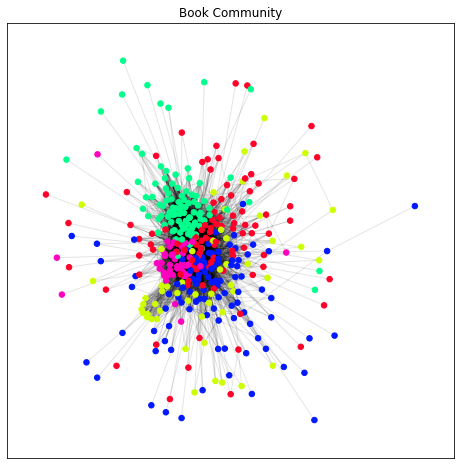

In [60]:
#vyberieme najvacsi komponent
Gcc = G_knihy.subgraph(sorted(nx.connected_components(G_knihy), key=len, reverse=True)[0])

#zadelime do komunit podla Louvian method
partition_knihy = community_louvain.best_partition(Gcc)

#zafarbime podla komunit
cmap = cm.get_cmap('gist_rainbow')#, max(partition_knihy.values()) + 1)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(Gcc, seed=42)
print(list(partition_knihy.values()))
nx.draw_networkx_nodes(Gcc, pos, partition_knihy.keys(), node_size=30, cmap=cmap, node_color=list(partition_knihy.values()))
nx.draw_networkx_edges(Gcc, pos, alpha=0.1)
plt.title("Book Community")
plt.show()